In [1]:
import os
import numpy as np
np.random.seed(69)
import pandas as pd
import random
import pickle as pkl
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
sns.set()
import tensorflow as tf
from tqdm.notebook import tqdm
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,concatenate, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, ZeroPadding2D, LeakyReLU, ReLU, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import time

# 1. Create Train/Val/Test Sets

In [2]:
X = np.load("../dataset/X_exp1.npy")

In [3]:
dnnx = np.load("../dataset/dnnx_exp1.npy")

In [4]:
objlist = np.load("../dataset/objlist_exp1.npy")

In [5]:
y = np.load("../dataset/y_exp1.npy", allow_pickle=True)

y, label_strings = pd.factorize(y,sort=True)
y = to_categorical(y)

print(label_strings)

['GALAXY' 'QSO' 'STAR']


In [6]:
zipX = list(zip(X, dnnx))
zipy = list(zip(y, objlist))

zipX_train, zipX_test, zipy_train, zipy_test = train_test_split(zipX, zipy, test_size = 0.125,random_state=42)
zipX_train, zipX_val, zipy_train, zipy_val = train_test_split(zipX_train, zipy_train, test_size = 0.1428, random_state=42)

X_train, dnnx_train = zip(*zipX_train)
X_val, dnnx_val = zip(*zipX_val)
X_test, dnnx_test = zip(*zipX_test)

y_train, objlist_train = zip(*zipy_train)
y_val, objlist_val = zip(*zipy_val)
y_test, objlist_test = zip(*zipy_test)

X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)

dnnx_train = np.array(dnnx_train)
dnnx_val = np.array(dnnx_val)
dnnx_test = np.array(dnnx_test)

y_train = np.array(y_train)
objlist_train = np.array(objlist_train)
y_val = np.array(y_val)
objlist_val = np.array(objlist_val)
y_test = np.array(y_test)
objlist_test = np.array(objlist_test)


del(zipX,zipX_test,zipX_train,zipX_val, X, zipy, zipy_test, zipy_train, zipy_val, objlist)

In [7]:
def get_metrics(y_pred, y_test, labels, to_print=True):
    correct_labels = np.where(y_pred==y_test)[0]
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred,average='macro')
    recall = metrics.recall_score(y_test, y_pred,average='macro')
    f1score = metrics.f1_score(y_test, y_pred,average='macro')
    # rocscore = metrics.roc_auc_score(y_test, y_pred,average='micro',multi_class="ovo")
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred)  
    classification_report = metrics.classification_report(y_test, y_pred)

    if to_print:
        print("Identified {} correct labels out of {} labels".format(len(correct_labels), y_test.shape[0]))
        print("Accuracy:",accuracy)
        print("Precision:",precision)
        print("Recall:",recall)
        print("F1 Score:",f1score)
        # print("ROC AUC Score:",rocscore)
        print(f"Labels are: {labels}")
        print("Confusion Matrix:\n", confusion_matrix)
        print("Classification_Report:\n", classification_report)

    return (correct_labels, accuracy, precision, recall, confusion_matrix, classification_report)

In [8]:
def plot_model_change(history,fname="output/time.pdf"):
    # summarize history for accuracy
    plt.plot(history.history['accuracy'],label="Training Acc")
    plt.plot(history.history['val_accuracy'],label="Val Acc")
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'],label="Training Loss")
    plt.plot(history.history['val_loss'],label="Val Loss")
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend()
    plt.savefig(fname)
    plt.show()

# 2. Train a DNN Classifier

In [9]:
model = Sequential()

model.add(Dense(1024, activation="sigmoid", input_dim=dnnx_train.shape[1]))
model.add(Dropout(0.25))
model.add(Dense(256, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(128, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(64, activation="sigmoid"))
model.add(Dropout(0.25))
model.add(Dense(32, activation="sigmoid"))
model.add(Dropout(0.25))

model.add(Dense(3, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', verbose=0, patience=100, restore_best_weights=True)
cb = [es]
history = model.fit(dnnx_train, y_train,
                    batch_size=2048,
                    epochs = 4000,
                    validation_data = (dnnx_val,y_val),
                    callbacks = cb,
                    verbose = 2)

Epoch 1/4000
88/88 - 1s - loss: 1.1102 - accuracy: 0.3661 - val_loss: 0.9145 - val_accuracy: 0.5666
Epoch 2/4000
88/88 - 0s - loss: 0.7676 - accuracy: 0.6128 - val_loss: 0.6135 - val_accuracy: 0.7483
Epoch 3/4000
88/88 - 0s - loss: 0.6160 - accuracy: 0.7467 - val_loss: 0.5024 - val_accuracy: 0.8202
Epoch 4/4000
88/88 - 0s - loss: 0.5425 - accuracy: 0.8003 - val_loss: 0.4591 - val_accuracy: 0.8373
Epoch 5/4000
88/88 - 0s - loss: 0.5017 - accuracy: 0.8210 - val_loss: 0.4350 - val_accuracy: 0.8483
Epoch 6/4000
88/88 - 0s - loss: 0.4810 - accuracy: 0.8298 - val_loss: 0.4240 - val_accuracy: 0.8502
Epoch 7/4000
88/88 - 0s - loss: 0.4660 - accuracy: 0.8348 - val_loss: 0.4141 - val_accuracy: 0.8518
Epoch 8/4000
88/88 - 0s - loss: 0.4496 - accuracy: 0.8391 - val_loss: 0.3981 - val_accuracy: 0.8575
Epoch 9/4000
88/88 - 0s - loss: 0.4345 - accuracy: 0.8421 - val_loss: 0.3835 - val_accuracy: 0.8598
Epoch 10/4000
88/88 - 0s - loss: 0.4196 - accuracy: 0.8454 - val_loss: 0.3682 - val_accuracy: 0.8626

In [10]:
model.save("output/DNNClassifier.h5")

In [11]:
plot_model(model,"output/DNNMod.pdf",show_shapes=True)

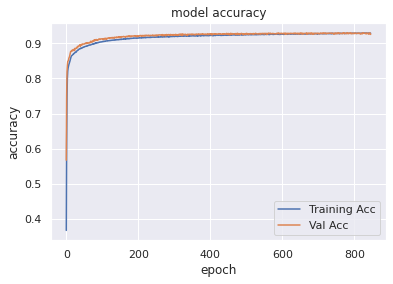

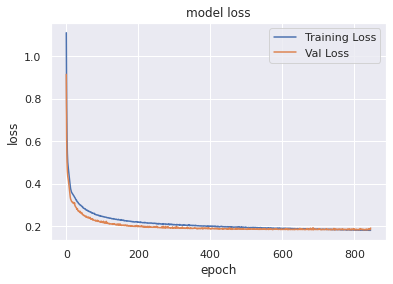

In [12]:
plot_model_change(history,fname="output/DNNTraining.pdf")

In [13]:
preds_test = model.predict(dnnx_test,batch_size=2048, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 27890 correct labels out of 30000 labels
Accuracy: 0.9296666666666666
Precision: 0.930187343825422
Recall: 0.9296465743591963
F1 Score: 0.9297919253175636
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[9490  382  148]
 [ 296 9246  459]
 [ 126  699 9154]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.95     10020
           1       0.90      0.92      0.91     10001
           2       0.94      0.92      0.93      9979

    accuracy                           0.93     30000
   macro avg       0.93      0.93      0.93     30000
weighted avg       0.93      0.93      0.93     30000

(array([    0,     1,     2, ..., 29997, 29998, 29999]), 0.9296666666666666, 0.930187343825422, 0.9296465743591963, array([[9490,  382,  148],
       [ 296, 9246,  459],
       [ 126,  699, 9154]]), '              precision    recall  f1-score   support\n\n           0       0.96      0.95      0.95     10020\n       

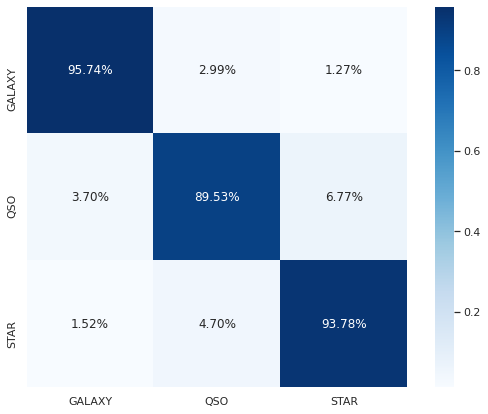

In [14]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("output/dnn_cm.pdf")

In [15]:
del(dnnx_train)

# 3. Train a CNN Classifier

In [16]:
inp_layer = tf.keras.Input(shape=X_train.shape[1:])

mod = Conv2D(filters=64, kernel_size=(5,5), padding='same')(inp_layer)
mod = ReLU()(mod)

c1 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c1 = ReLU()(c1)
c2 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c2 = ReLU()(c2)
c3 = Conv2D(filters=48, kernel_size=(1,1), padding='same')(mod)
c3 = ReLU()(c3)
c4 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(c1)
c4 = ReLU()(c4)
c5 = Conv2D(filters=64, kernel_size=(3,3), padding='same')(c1)
c5 = ReLU()(c5)
c6 = Conv2D(filters=64, kernel_size=(5,5), padding='same')(c2)
c6 = ReLU()(c6)
p1 = AveragePooling2D(pool_size=(1, 1))(c3)
mod = concatenate([c4,c5,c6,p1])

c7 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c7 = ReLU()(c7)
c8 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c8 = ReLU()(c8)
c9 = Conv2D(filters=64, kernel_size=(1,1), padding='same')(mod)
c9 = ReLU()(c9)
c10 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(c7)
c10 = ReLU()(c10)
c11 = Conv2D(filters=92, kernel_size=(3,3), padding='same')(c7)
c11 = ReLU()(c11)
c12 = Conv2D(filters=92, kernel_size=(5,5), padding='same')(c8)
c12 = ReLU()(c12)
p2 = AveragePooling2D(pool_size=(1, 1))(c9)
mod = concatenate([c10,c11,c12,p2])
mod = AveragePooling2D(pool_size=(2, 2))(mod)

c13 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c13 = ReLU()(c13)
c14 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c14 = ReLU()(c14)
c15 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c15 = ReLU()(c15)
c16 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(c13)
c16 = ReLU()(c16)
c17 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c13)
c17 = ReLU()(c17)
c18 = Conv2D(filters=128, kernel_size=(5,5), padding='same')(c14)
c18 = ReLU()(c18)
p3 = AveragePooling2D(pool_size=(1, 1))(c15)
mod = concatenate([c16,c17,c18,p3])

c19 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c19 = ReLU()(c19)
c20 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c20 = ReLU()(c20)
c21 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c21 = ReLU()(c21)
c22 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(c19)
c22 = ReLU()(c22)
c23 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c19)
c23 = ReLU()(c23)
c24 = Conv2D(filters=128, kernel_size=(5,5), padding='same')(c20)
c24 = ReLU()(c24)
p4 = AveragePooling2D(pool_size=(1, 1))(c21)
mod = concatenate([c22,c23,c24,p4])
mod = AveragePooling2D(pool_size=(2, 2))(mod)

c25 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c25 = ReLU()(c25)
c26 = Conv2D(filters=92, kernel_size=(1,1), padding='same')(mod)
c26 = ReLU()(c26)
c27 = Conv2D(filters=128, kernel_size=(1,1), padding='same')(mod)
c27 = ReLU()(c27)
c28 = Conv2D(filters=128, kernel_size=(3,3), padding='same')(c25)
c28 = ReLU()(c28)
p5 = AveragePooling2D(pool_size=(1, 1))(c26)
mod = concatenate([c27,c28,p5])
mod = Flatten()(mod)    #Check
mod = Dense(1024)(mod)
mod = Dense(1024)(mod)
out_layer = Dense(3, activation="softmax") (mod)
model = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

model.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])


In [17]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)
datagen.fit(X_train)


es = EarlyStopping(monitor='val_loss', verbose=1, patience=30, restore_best_weights=True)

cb = [es]


/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (180011, 32, 32, 5) (5 channels).
  ' channels).')


In [18]:
history = model.fit(datagen.flow(X_train,y_train, batch_size=512),
                              epochs = 300, validation_data = (X_val,y_val),
                              callbacks = cb,
                              verbose = 1)

/opt/conda/lib/python3.7/site-packages/keras_preprocessing/image/numpy_array_iterator.py:136: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (180011, 32, 32, 5) (5 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


Epoch 1/300
352/352 [==============================] - 176s 499ms/step - loss: 0.4619 - accuracy: 0.8153 - val_loss: 0.3253 - val_accuracy: 0.8808
Epoch 2/300
352/352 [==============================] - 176s 500ms/step - loss: 0.3135 - accuracy: 0.8809 - val_loss: 0.2951 - val_accuracy: 0.8865
Epoch 3/300
352/352 [==============================] - 176s 500ms/step - loss: 0.2930 - accuracy: 0.8880 - val_loss: 0.2933 - val_accuracy: 0.8886
Epoch 4/300
352/352 [==============================] - 177s 503ms/step - loss: 0.2802 - accuracy: 0.8925 - val_loss: 0.2729 - val_accuracy: 0.8951
Epoch 5/300
352/352 [==============================] - 178s 507ms/step - loss: 0.2723 - accuracy: 0.8944 - val_loss: 0.2566 - val_accuracy: 0.9001
Epoch 6/300
352/352 [==============================] - 179s 509ms/step - loss: 0.2639 - accuracy: 0.8974 - val_loss: 0.2630 - val_accuracy: 0.9003
Epoch 7/300
352/352 [==============================] - 177s 502ms/step - loss: 0.2599 - accuracy: 0.8992 - val_loss: 0

In [19]:
model.save("output/CNNClassifier.h5")

In [20]:
plot_model(model,"output/CNNMod.pdf",show_shapes=True)

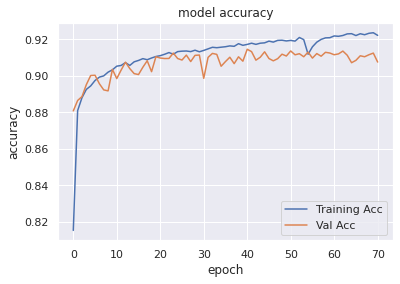

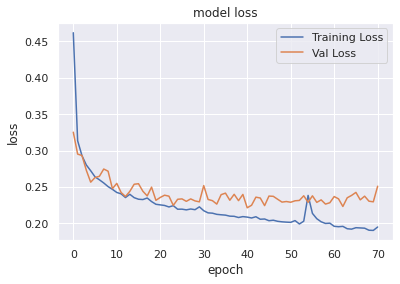

In [21]:
plot_model_change(history,fname="output/CNNTraining.pdf")

In [22]:
preds_test = model.predict(X_test,batch_size=1024, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 27480 correct labels out of 30000 labels
Accuracy: 0.916
Precision: 0.9166998156433928
Recall: 0.915984589578169
F1 Score: 0.9161752872764594
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[9305  498  217]
 [ 353 9135  513]
 [ 184  755 9040]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.95      0.93      0.94     10020
           1       0.88      0.91      0.90     10001
           2       0.93      0.91      0.92      9979

    accuracy                           0.92     30000
   macro avg       0.92      0.92      0.92     30000
weighted avg       0.92      0.92      0.92     30000

(array([    0,     1,     2, ..., 29997, 29998, 29999]), 0.916, 0.9166998156433928, 0.915984589578169, array([[9305,  498,  217],
       [ 353, 9135,  513],
       [ 184,  755, 9040]]), '              precision    recall  f1-score   support\n\n           0       0.95      0.93      0.94     10020\n           1       0.88      0.91

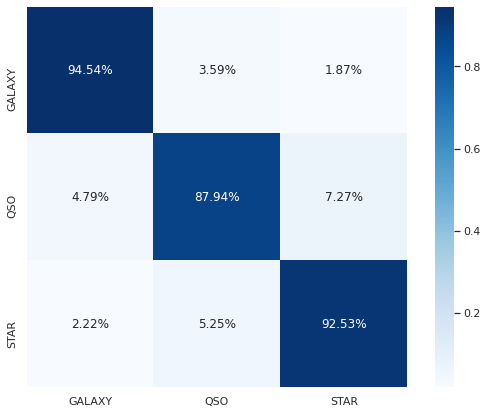

In [23]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("cnn_cm.pdf")

In [24]:
del(X_train)

# 4. Train the Ensemble Classifier

In [25]:
cnnclassifier = load_model("output/CNNClassifier.h5")
dnnclassifier = load_model("output/DNNClassifier.h5")

In [26]:
def define_stacked_model(members):
    # update all layers in all models to not be trainable
    for i in range(len(members)):
        model = members[i]
        for layer in model.layers:
            # make not trainable
            layer.trainable = False
            # rename to avoid 'unique layer name' issue
            layer._name = 'ensemble_' + str(i+1) + '_' + layer.name
    # define multi-headed input
    ensemble_visible = [model.input for model in members]
    # concatenate merge output from each model
    ensemble_outputs = [model.output for model in members]
    merge = tf.keras.layers.concatenate(ensemble_outputs)
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(3, activation='softmax')(hidden)
    model = tf.keras.Model(inputs=ensemble_visible, outputs=output)
    # plot graph of ensemble
    plot_model(model, show_shapes=True, to_file='model_graph.png')
    # compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
# define ensemble model
members = [cnnclassifier,dnnclassifier]
model = define_stacked_model(members)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
filepath="output/EnsembleClassifier.h5"

checkpointcb = tf.keras.callbacks.ModelCheckpoint(filepath=filepath,monitor='loss',mode='min',save_best_only=True,verbose=1,save_weights_only=False)
cb = [checkpointcb]


In [29]:
history = model.fit([X_val, dnnx_val],
                            y_val, epochs=100,
                            batch_size=512,
                            callbacks=cb,
                            verbose=1)

Epoch 1/100
59/59 [==============================] - ETA: 0s - loss: 1.2855 - accuracy: 0.0360
Epoch 00001: loss improved from inf to 1.28553, saving model to EnsembleClassifier.h5
59/59 [==============================] - 7s 113ms/step - loss: 1.2855 - accuracy: 0.0360
Epoch 2/100
59/59 [==============================] - ETA: 0s - loss: 1.0646 - accuracy: 0.4235
Epoch 00002: loss improved from 1.28553 to 1.06456, saving model to EnsembleClassifier.h5
59/59 [==============================] - 6s 108ms/step - loss: 1.0646 - accuracy: 0.4235
Epoch 3/100
59/59 [==============================] - ETA: 0s - loss: 0.8474 - accuracy: 0.9120
Epoch 00003: loss improved from 1.06456 to 0.84736, saving model to EnsembleClassifier.h5
59/59 [==============================] - 6s 108ms/step - loss: 0.8474 - accuracy: 0.9120
Epoch 4/100
59/59 [==============================] - ETA: 0s - loss: 0.6441 - accuracy: 0.9256
Epoch 00004: loss improved from 0.84736 to 0.64412, saving model to EnsembleClassifier.

In [30]:
del(X_val, dnnx_val)

In [31]:
model = load_model("output/EnsembleClassifier.h5")

In [32]:
model.evaluate([X_test, dnnx_test],y_test)

938/938 [==============================] - 10s 11ms/step - loss: 0.1911 - accuracy: 0.9332


[0.19114574790000916, 0.9332333207130432]

In [33]:
plot_model(model,"output/EnsembleMod.pdf",show_shapes=True)

In [34]:
preds_test = model.predict([X_test, dnnx_test],batch_size=512, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 27997 correct labels out of 30000 labels
Accuracy: 0.9332333333333334
Precision: 0.9333156684689717
Recall: 0.933217720394221
F1 Score: 0.9332602061738186
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[9553  317  150]
 [ 291 9170  540]
 [ 120  585 9274]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.96      0.95      0.96     10020
           1       0.91      0.92      0.91     10001
           2       0.93      0.93      0.93      9979

    accuracy                           0.93     30000
   macro avg       0.93      0.93      0.93     30000
weighted avg       0.93      0.93      0.93     30000

(array([    0,     1,     2, ..., 29997, 29998, 29999]), 0.9332333333333334, 0.9333156684689717, 0.933217720394221, array([[9553,  317,  150],
       [ 291, 9170,  540],
       [ 120,  585, 9274]]), '              precision    recall  f1-score   support\n\n           0       0.96      0.95      0.96     10020\n       

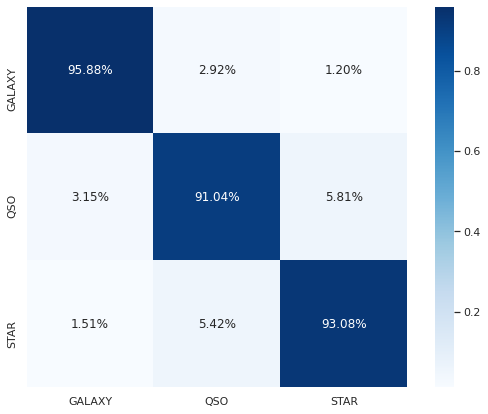

In [35]:
cm = metrics.confusion_matrix(preds_test.argmax(axis=1), y_test.argmax(axis=1),normalize='true')
df_cm = pd.DataFrame(cm, index = label_strings,columns = label_strings)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="Blues",square=True,fmt='.2%')
plt.savefig("output/ensemble_cm.pdf")

# 5. Analyse Results

In [36]:
model = load_model("output/EnsembleClassifier.h5")

In [37]:
preds_train = model.predict([X_train, dnnx_train],batch_size=512, verbose = 0)
print(get_metrics(preds_train.argmax(axis=1), y_train.argmax(axis=1),label_strings))

Identified 168981 correct labels out of 180011 labels
Accuracy: 0.9387259667464766
Precision: 0.9387949859392456
Recall: 0.9387145758823535
F1 Score: 0.9387464153870226
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[57705  1764   592]
 [ 1674 55272  3016]
 [  571  3413 56004]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     60061
           1       0.91      0.92      0.92     59962
           2       0.94      0.93      0.94     59988

    accuracy                           0.94    180011
   macro avg       0.94      0.94      0.94    180011
weighted avg       0.94      0.94      0.94    180011

(array([     0,      1,      2, ..., 180008, 180009, 180010]), 0.9387259667464766, 0.9387949859392456, 0.9387145758823535, array([[57705,  1764,   592],
       [ 1674, 55272,  3016],
       [  571,  3413, 56004]]), '              precision    recall  f1-score   support\n\n           0       0.96      0.96 

In [38]:
del(dnnx_train,X_train)

In [39]:
preds_val = model.predict([X_val, dnnx_val],batch_size=512, verbose = 0)
print(get_metrics(preds_val.argmax(axis=1), y_val.argmax(axis=1),label_strings))

Identified 27951 correct labels out of 29988 labels
Accuracy: 0.9320728291316527
Precision: 0.9322192094283954
Recall: 0.9321634242566498
F1 Score: 0.9321845593955201
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[9473  328  117]
 [ 333 9167  537]
 [ 115  607 9311]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95      9918
           1       0.91      0.91      0.91     10037
           2       0.93      0.93      0.93     10033

    accuracy                           0.93     29988
   macro avg       0.93      0.93      0.93     29988
weighted avg       0.93      0.93      0.93     29988

(array([    0,     1,     2, ..., 29985, 29986, 29987]), 0.9320728291316527, 0.9322192094283954, 0.9321634242566498, array([[9473,  328,  117],
       [ 333, 9167,  537],
       [ 115,  607, 9311]]), '              precision    recall  f1-score   support\n\n           0       0.95      0.96      0.95      9918\n     

In [40]:
del(X_val, dnnx_val)

In [41]:
preds_test = model.predict([X_test, dnnx_test],batch_size=512, verbose = 0)
print(get_metrics(preds_test.argmax(axis=1), y_test.argmax(axis=1),label_strings))

Identified 27999 correct labels out of 30000 labels
Accuracy: 0.9333
Precision: 0.9333117964761226
Recall: 0.9332824843769045
F1 Score: 0.9332960665290292
Labels are: ['GALAXY' 'QSO' 'STAR']
Confusion Matrix:
 [[9583  298  139]
 [ 313 9142  546]
 [ 114  591 9274]]
Classification_Report:
               precision    recall  f1-score   support

           0       0.96      0.96      0.96     10020
           1       0.91      0.91      0.91     10001
           2       0.93      0.93      0.93      9979

    accuracy                           0.93     30000
   macro avg       0.93      0.93      0.93     30000
weighted avg       0.93      0.93      0.93     30000

(array([    0,     1,     2, ..., 29997, 29998, 29999]), 0.9333, 0.9333117964761226, 0.9332824843769045, array([[9583,  298,  139],
       [ 313, 9142,  546],
       [ 114,  591, 9274]]), '              precision    recall  f1-score   support\n\n           0       0.96      0.96      0.96     10020\n           1       0.91      

In [42]:
df = pd.read_csv("../dataset/photofeatures_exp1.csv",index_col=0)

In [43]:
df.loc[objlist_train, ["set"]] = "TRAIN"
df.loc[objlist_val, ["set"]] = "VALIDATION"
df.loc[objlist_test, ["set"]] = "TEST"

In [44]:
df.loc[objlist_train, ["pred_class"]] = label_strings[preds_train.argmax(axis=1)]
df.loc[objlist_val, ["pred_class"]] = label_strings[preds_val.argmax(axis=1)]
df.loc[objlist_test, ["pred_class"]] = label_strings[preds_test.argmax(axis=1)]

In [45]:
pgal_train = preds_train[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_train = preds_train[:,np.where(label_strings=="STAR")[0][0]]
pqso_train = preds_train[:,np.where(label_strings=="QSO")[0][0]]

pgal_val = preds_val[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_val = preds_val[:,np.where(label_strings=="STAR")[0][0]]
pqso_val = preds_val[:,np.where(label_strings=="QSO")[0][0]]

pgal_test = preds_test[:,np.where(label_strings=="GALAXY")[0][0]]
pstar_test = preds_test[:,np.where(label_strings=="STAR")[0][0]]
pqso_test = preds_test[:,np.where(label_strings=="QSO")[0][0]]

In [46]:
df.loc[objlist_train, ["prob_gal"]] = pgal_train
df.loc[objlist_train, ["prob_star"]] = pstar_train
df.loc[objlist_train, ["prob_qso"]] = pqso_train

df.loc[objlist_val, ["prob_gal"]] = pgal_val
df.loc[objlist_val, ["prob_star"]] = pstar_val
df.loc[objlist_val, ["prob_qso"]] = pqso_val

df.loc[objlist_test, ["prob_gal"]] = pgal_test
df.loc[objlist_test, ["prob_star"]] = pstar_test
df.loc[objlist_test, ["prob_qso"]] = pqso_test

In [47]:
df.to_csv("output/star_galaxy_qso_results_exp1.csv")

In [48]:
subdf = df.loc[df["set"]=="TEST",["class","pred_class",'prob_gal', 'prob_star', 'prob_qso']]

In [49]:
subdf[(subdf["pred_class"]!=subdf["class"]) & (subdf["pred_class"]=="GALAXY")]["prob_gal"].min()

0.37265077233314514